In [3]:
# Imports
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.datasets import fetch_20newsgroups
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import time
import sys
import torch
from sklearn.metrics import f1_score
from nltk import word_tokenize
from nltk.corpus import stopwords
import string, re
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, balanced_accuracy_score 
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,roc_curve, classification_report)
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from flair.embeddings import FlairEmbeddings,ELMoEmbeddings, WordEmbeddings
from flair.embeddings import DocumentPoolEmbeddings, FastTextEmbeddings ,Sentence, XLNetEmbeddings
from sentence_transformers import SentenceTransformer
from sklearn.neural_network import MLPClassifier

In [7]:
dir = "/opt/notebooks/datasets/news20"
if dir not in nltk.data.path:
    nltk.data.path.append(dir)
nltk.download('stopwords')
nltk.download('punkt')

def clean_text(text: str, rm_numbers=True, rm_punct=True, rm_stop_words=True, rm_short_words=True):
    """ Function to perform common NLP pre-processing tasks. """

    # make lowercase
    text = text.lower()
    # remove punctuation
    if rm_punct:
        text = text.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))
    # remove numbers
    if rm_numbers:
        text = re.sub(r'\d+', '', text)
    # remove whitespaces
    text = text.strip()
    # remove stopwords
    if rm_stop_words:
        stop_words = set(stopwords.words('english'))
        word_tokens = word_tokenize(text)
        text_list = [w for w in word_tokens if not w in stop_words]
        text = ' '.join(text_list)
    # remove short words
    if rm_short_words:
        text_list = [w for w in text.split() if len(w) >= 3]
        text = ' '.join(text_list)
    return text

def newsgroups20_dataset_train(directory=dir,train=True, test=False, clean_txt=True):
    """
    Load the 20 Newsgroups dataset.
    """
    splits = [split_set for (requested, split_set) in [(train, 'train'), (test, 'test')] if requested]
    for split_set in splits:
        dataset = fetch_20newsgroups(data_home=directory, subset=split_set, remove=('headers', 'footers', 'quotes'))
        train = []
        for id in range(len(dataset.data)):
            if clean_txt:
                text = clean_text(dataset.data[id])
            else:
                text = ' '.join(word_tokenize(dataset.data[id]))
            label = dataset.target_names[int(dataset.target[id])]

            if text:
                train.append({
                    'text': text,
                    'label': label
                })
    return train
  
def newsgroups20_dataset_test(directory=dir,train=False, test=True, clean_txt=True):
    """
    Load the 20 Newsgroups dataset.
    """
    splits = [split_set for (requested, split_set) in [(train, 'train'), (test, 'test')] if requested]
    for split_set in splits:
        dataset = fetch_20newsgroups(data_home=directory, subset=split_set, remove=('headers', 'footers', 'quotes'))
        test = []
        for id in range(len(dataset.data)):
            if clean_txt:
                text = clean_text(dataset.data[id])
            else:
                text = ' '.join(word_tokenize(dataset.data[id]))
            label = dataset.target_names[int(dataset.target[id])]

            if text:
                test.append({
                    'text': text,
                    'label': label
                })
    return test

[nltk_data] Downloading package stopwords to /home/runner/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/runner/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Various Embeddings - Bert, Universal Sentence Encoder, Infersent, GloVe, Fasttext, Ensemble Embeddings(Flair + GloVe)

In [8]:
# Embedding using Universal Sentence Encoder
def embed_module(module):
    with tf.Graph().as_default():
        sentences = tf.placeholder(tf.string)
        embed = hub.Module(module)
        embeddings = embed(sentences)
        session = tf.train.MonitoredSession()
    return lambda x: session.run(embeddings, {sentences: x})

def use_embeddings():
    train_data_list = []
    test_data_list = []
    module_url = "/opt/notebooks/embedding_model/"
    # Import the Universal Sentence Encoder's TF Hub module
    embed = embed_module(module_url)
    train_data_list = embed(final_train['text'].tolist())
    test_data_list = embed(final_test['text'].tolist())
    return train_data_list, test_data_list

# Bert
def bert_embeddings():
    train_data_list = []
    test_data_list = []
    model = SentenceTransformer('bert-base-nli-mean-tokens')
    train_data_list = model.encode(final_train['text'].tolist())
    test_data_list = model.encode(final_test['text'].tolist())
    return train_data_list, test_data_list

# Flair - GloVe - XLNet - FastText
def other_embeddings(embd):
    sess = tf.InteractiveSession()
    train_data_list = []
    test_data_list = []
    if embd == 'glove':
        print('Starting Glove Embedding...')
        glove_embedding = WordEmbeddings('glove')
        document_embeddings = DocumentPoolEmbeddings(embeddings=[glove_embedding])
    elif embd == 'fasttext':
        print('Starting Fasttext Embedding...')
        fasttext_embedding = WordEmbeddings('en')
        document_embeddings = DocumentPoolEmbeddings(embeddings=[fasttext_embedding])
    elif embd == 'elmo':
        print('Starting ELMo Embedding...')
        elmo_embedding = ELMoEmbeddings()
        document_embeddings = DocumentPoolEmbeddings(embeddings=[elmo_embedding])
    else:
        # init Flair embeddings
        flair_forward_embedding = FlairEmbeddings('multi-forward')
        flair_backward_embedding = FlairEmbeddings('multi-backward')
        glove_embedding = WordEmbeddings('glove')
        # now create the DocumentPoolEmbeddings object that combines all embeddings
        document_embeddings = DocumentPoolEmbeddings(embeddings=[glove_embedding, flair_forward_embedding, 
                                                                 flair_backward_embedding])
    print('Train embedding Started...')
    for text in final_train['text'].tolist():
        text = Sentence(text)
        document_embeddings.embed(text)
        emb = text.get_embedding().detach().numpy()
        emb = tf.constant(emb).eval()
        train_data_list.append(emb)
    print('Embedded Train data!!')
    print('Test embedding Started...')
    for text in final_test['text'].tolist():
        text = Sentence(text)
        document_embeddings.embed(text)
        emb = text.get_embedding().detach().numpy()
        emb = tf.constant(emb).eval()
        test_data_list.append(emb)
    print('Embedded Test data!!')
    return train_data_list, test_data_list

def elmo_vectors(x):
    elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
    embeddings = elmo(x, signature="default", as_dict=True)["elmo"]
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.tables_initializer())
        # return average of ELMo features
        return sess.run(tf.reduce_mean(embeddings,1))
        
def elmo_embeddings():
    train_data_list = []
    test_data_list = []
    
    elmo_train = [elmo_vectors(final_train['text'].tolist())]
    elmo_test = [elmo_vectors(final_test['text'].tolist())]
    for i in range(len(final_train['text'].tolist())):
        train_data_list.append(elmo_train[0][i])
    for i in range(len(final_test['text'].tolist())):
        test_data_list.append(elmo_test[0][i])
    return train_data_list, test_data_list

def infersent_embeddings():
    train_data_list = []
    test_data_list = []
    sys.path.append('/opt/notebooks/OCSVM_ISF_LOF_USE_Baselines/InferSent-master')
    # Load model
    from models import InferSent
    model_version = 1
    MODEL_PATH = "/opt/notebooks/OCSVM_ISF_LOF_USE_Baselines/InferSent-master/encoder/infersent%s.pkl" % model_version
    params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                    'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}
    model = InferSent(params_model)
    model.load_state_dict(torch.load(MODEL_PATH))
    # Keep it on CPU or put it on GPU
    use_cuda = False
    model = model.cuda() if use_cuda else model
    # If infersent1 -> use GloVe embeddings. If infersent2 -> use InferSent embeddings.
    W2V_PATH = '/opt/notebooks/OCSVM_ISF_LOF_USE_Baselines/InferSent-master/glove.840B.300d-003.txt' if model_version == 1 else '/opt/notebooks/OCSVM_ISF_LOF_USE_Baselines/InferSent-master/fastText/crawl-300d-2M.vec'
    model.set_w2v_path(W2V_PATH)
    # Load embeddings of K most frequent words
    model.build_vocab_k_words(K=100000)
    train_data_list = model.encode(final_train['text'].tolist(), bsize=128, tokenize=False, verbose=True)
    print('nb sentences encoded : {0}'.format(len(train_data_list)))
    test_data_list = model.encode(final_test['text'].tolist(), bsize=128, tokenize=False, verbose=True)
    print('nb sentences encoded : {0}'.format(len(test_data_list)))
    return train_data_list, test_data_list

In [9]:

# OCSVM model
def oneclass_svm(dataset, kernel, nu):
    svm = OneClassSVM(kernel=kernel, nu=nu).fit(dataset)
    return svm
  
# Isolation Forest
def isolationForest(dataset, rng):
    isolationforest = IsolationForest(behaviour='new', max_samples=100, random_state=rng, contamination='auto').fit(dataset)
    return isolationforest

def local_outlier_factory(dataset, neighbours):
    lof = LocalOutlierFactor(n_neighbors=neighbours, contamination=0.1,novelty=True).fit(dataset)
    return lof

def pca(train, test):
    print('Principal Component Analysis ...')
    ss = StandardScaler()
    ss.fit(train)
    train = ss.transform(train)
    test = ss.transform(test)
    pca = PCA()
    pca = pca.fit(train)
    print('Explained variance percentage = %0.2f' % sum(pca.explained_variance_ratio_))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance')
    train = pca.transform(train)
    test = pca.transform(test)
    return train, test

def results(model, train_true_labels, train_predicted_labels, test_true_labels, test_predicted_labels):
    print('Model: ', model)
    train_f1 = f1_score(train_true_labels, train_predicted_labels, average='macro')  
    #print('Train F1 Score: ', train_f1)
    test_f1 = f1_score(test_true_labels, test_predicted_labels, average='macro')  
    print('Test F1 Score: ', test_f1)
    #print("Train accuracy:", accuracy_score(train_true_labels, train_predicted_labels))
    accuracy = accuracy_score(test_true_labels, test_predicted_labels)
    print("Test accuracy:", accuracy )
    #results_global_list.append(test_f1)
    #results_global_list.append(accuracy)
    results = confusion_matrix(test_true_labels, test_predicted_labels, [1,-1]) 
    #print('Confusion Matrix :')
    #print(results) 
    #print('Report : ')
    LABELS = ["known", "unknown"]
    plt.figure(figsize=(6, 6))
    sns.heatmap(results, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix - Reuters - " + str(model))
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print(classification_report(test_true_labels, test_predicted_labels))
    return test_f1, accuracy
    

In [10]:
train_data = newsgroups20_dataset_train()
test_data = newsgroups20_dataset_test()

In [11]:
# Converting the train and test data into dataframe
train_data_df = pd.DataFrame(train_data, columns = ['text' , 'label'])
test_data_df = pd.DataFrame(test_data, columns = ['text' , 'label'])

In [12]:
train_data_df['text'][15]

'certainly use whenever tiff usually works well point philosophically opposed complexity complexity led programs poor tiff writers making bizarre files programs inability load tiff images though save course general inability interchange images different environments despite fact think understand tiff saying goes worried abuse tiff years chalk immense unnecessary complexity format words tiff spec appendix page capitalized emphasis mine problem sort success tiff designed powerful flexible expense simplicity takes fair amount effort handle options currently defined specification probably application complete job currently way sure able import tiff image since many image generating applications program worse applications read every tiff image means might deal would want images trapped format neither anyone agrees reasoning anyone course'

In [16]:
group_list = ['rec.autos', 'comp.sys.mac.hardware', 'comp.graphics', 'sci.space',
       'talk.politics.guns', 'sci.med', 'comp.sys.ibm.pc.hardware',
       'comp.os.ms-windows.misc', 'rec.motorcycles', 'talk.religion.misc',
       'misc.forsale', 'alt.atheism', 'sci.electronics', 'comp.windows.x',
       'rec.sport.hockey', 'rec.sport.baseball', 'soc.religion.christian',
       'talk.politics.mideast', 'talk.politics.misc', 'sci.crypt']

TRAIN_CLASS = 'rec.sport.hockey'
results_global_list = []

def data_for_sota():
    # Numerical Labeling - 1 for normal class; -1 for anomaly class                    
    train_data_df['new_label'] = train_data_df['label']
    train_data_df.loc[train_data_df['label'] == TRAIN_CLASS, 'new_label'] = 1
    train_data_df.loc[train_data_df['label'] != TRAIN_CLASS, 'new_label'] = -1
    test_data_df['new_label'] = test_data_df['label']
    test_data_df.loc[test_data_df['label'] == TRAIN_CLASS, 'new_label'] = 1
    test_data_df.loc[test_data_df['label'] != TRAIN_CLASS, 'new_label'] = -1
    # Preparing train data with only normal class
    final_train = train_data_df.loc[train_data_df['new_label'] == 1]
    print(final_train['new_label'].value_counts())
    # Test data with both normal and other classes
    final_test = test_data_df
    print(final_test['new_label'].value_counts())
    return final_train, final_test

In [17]:
final_train, final_test = data_for_sota()

1    584
Name: new_label, dtype: int64
-1    6910
 1     389
Name: new_label, dtype: int64


In [18]:
final_train.head()

,text,label,new_label
20,think mike foligno captain sabres got traded l...,rec.sport.hockey,1
34,funny mention one time hnic cherry pointed van...,rec.sport.hockey,1
56,squid keep tradition alive kinda like fish unh...,rec.sport.hockey,1
87,soderstrom plays philly moulded mask got helme...,rec.sport.hockey,1
112,well see smileys trying figure poster dog word...,rec.sport.hockey,1


In [19]:
# Specify the embeddings 'glove', 'xlnet', 'fasttext', 'elmo', 'ensemble'
train_data_list_global, test_data_list_global = use_embeddings()
#train_data_list_global, test_data_list_global = bert_embeddings()
#train_data_list_global, test_data_list_global = infersent_embeddings()
#train_data_list_global, test_data_list_global = elmo_embeddings()
#train_data_list_global, test_data_list_global = other_embeddings('elmo')

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0107 12:08:02.875921 140119074080128 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Graph was finalized.


I0107 12:08:03.329111 140119074080128 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0107 12:08:05.048934 140119074080128 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0107 12:08:07.181462 140119074080128 session_manager.py:493] Done running local_init_op.


Principal Component Analysis ...
Explained variance percentage = 1.00


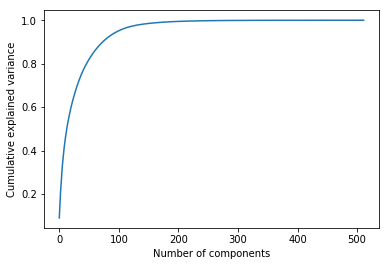

In [20]:
train_data_list = train_data_list_global
test_data_list = test_data_list_global
train_data_list, test_data_list = pca(train_data_list, test_data_list)
members = []

Model:  one Class SVM
Test F1 Score:  0.8864618830712077
Test accuracy: 0.9775311686532402


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


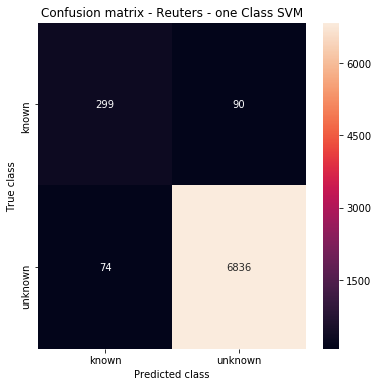

              precision    recall  f1-score   support

          -1       0.99      0.99      0.99      6910
           1       0.80      0.77      0.78       389

    accuracy                           0.98      7299
   macro avg       0.89      0.88      0.89      7299
weighted avg       0.98      0.98      0.98      7299

[2.09232496 2.72237431 2.43161451 ... 3.09282997 2.29940603 2.1934553 ]


In [21]:
svm_model = oneclass_svm(train_data_list, 'rbf', 0.1)
y_pred_train = svm_model.predict(train_data_list)
y_pred_test = svm_model.predict(test_data_list)
y_test_scores = svm_model.score_samples(test_data_list)
f1, acc = results('one Class SVM', final_train['new_label'].tolist(), y_pred_train, final_test['new_label'].tolist(), y_pred_test)
results_global_list.append(round(f1,2))
results_global_list.append(round(acc*100,1))
print(y_test_scores)
#norm_scores = [float(i)/sum(y_test_scores) for i in y_test_scores]
#print(norm_scores)
members.append(svm_model)


In [65]:
print(y_test_scores.tolist()[0])

0.593464017729605


In [22]:
score_list = y_test_scores.tolist()
normalized_svm = [((x-min(score_list))/(max(score_list)-min(score_list))) for x in score_list]
print(normalized_svm)

[0.1177972805757761, 0.34259087722278025, 0.23885147944781973, 0.22066389633070738, 0.172929971061139, 0.2419069372847909, 0.29104619481921395, 0.23340648527057914, 0.1880097939230726, 0.14539200215884837, 0.3282180768915591, 0.16911217655870592, 0.2722948239987676, 0.23939159722261238, 0.09231109366463028, 0.24678314909507246, 0.2849624283343257, 0.231445579053595, 0.31154940490106003, 0.2569413217958918, 0.4124521505782527, 0.2517936049135849, 0.22328174260479103, 0.267268292507639, 0.2608225385618401, 0.11351336795941235, 0.3602964666499656, 0.16355077851780553, 0.21115519649158274, 0.22235790527565938, 0.2660138760848345, 0.267579723156365, 0.19975279813591082, 0.3213594897823981, 0.40914304607884133, 0.1319917734874047, 0.678960617319291, 0.21612728130756145, 0.17386598995630828, 0.17151520848202806, 0.23337671062667692, 0.207551587704943, 0.2258061949892439, 0.2194422328277148, 0.18372413191754117, 0.42482030958778627, 0.27112107981968064, 0.47529616686283915, 0.23348677388320796

Model:  Isolation Forest
Test F1 Score:  0.5995755012105438
Test accuracy: 0.9532812714070421


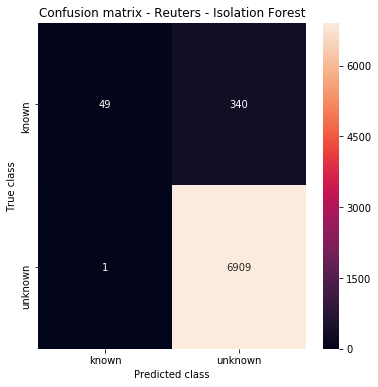

              precision    recall  f1-score   support

          -1       0.95      1.00      0.98      6910
           1       0.98      0.13      0.22       389

    accuracy                           0.95      7299
   macro avg       0.97      0.56      0.60      7299
weighted avg       0.95      0.95      0.94      7299

[0.2974304096854224, 0.21854305528926685, 0.25516045267378046, 0.29629303350403885, 0.28784132435741816, 0.317548960151681, 0.345424838130598, 0.36468226032401796, 0.27552801024239776, 0.3244341074864961, 0.315234074535411, 0.21981124214631292, 0.2650014092298204, 0.26057788425907574, 0.3297022831027893, 0.224104944102699, 0.21763570185381698, 0.3130309317573025, 0.3023212860671366, 0.4013359155656311, 0.3771044778705571, 0.2909536524653495, 0.2809869120533902, 0.2793171410482231, 0.24346262941169988, 0.3762779773719993, 0.2581208665352601, 0.23803212948160252, 0.16501848359180832, 0.24249242702341486, 0.21277544378107413, 0.1998676530284271, 0.24368791044573423, 0

In [23]:
rand_state = np.random.RandomState(42)
iso_forest = isolationForest(train_data_list, rand_state)
y_pred_iso_train = iso_forest.predict(train_data_list)
y_pred_iso_test = iso_forest.predict(test_data_list)
y_test_scores_isf = iso_forest.score_samples(test_data_list)
f1, acc = results('Isolation Forest', final_train['new_label'].tolist(), y_pred_iso_train, final_test['new_label'].tolist(), y_pred_iso_test)
results_global_list.append(round(f1,2))
results_global_list.append(round(acc*100,1))
members.append(iso_forest)

score_list = y_test_scores_isf.tolist()
normalized_isf = [((x-min(score_list))/(max(score_list)-min(score_list))) for x in score_list]
print(normalized_isf)

Model:  Local Outlier Factory
Test F1 Score:  0.47515860119793607
Test accuracy: 0.6717358542266064


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


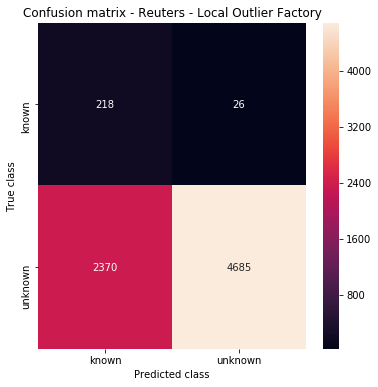

In [20]:
lof = local_outlier_factory(train_data_list, 180)
y_pred_lof_train = lof.predict(train_data_list)
y_pred_lof_test = lof.predict(test_data_list)
f1, acc = results('Local Outlier Factory', final_train['new_label'].tolist(), y_pred_lof_train, final_test['new_label'].tolist(), y_pred_lof_test)
results_global_list.append(round(f1,2))
results_global_list.append(round(acc*100,1))

In [608]:
print(results_global_list)

[0.58, 88.7, 0.54, 95.6, 0.48, 69.0]


In [24]:
# Converting the train and test data into dataframe
train_data_df = pd.DataFrame(train_data, columns = ['text' , 'label'])
test_data_df = pd.DataFrame(test_data, columns = ['text' , 'label'])

In [25]:
def data_for_autoencoder():
    # Converting the train and test data into dataframe
    train_data_df['new_label'] = train_data_df['label']
    train_data_df.loc[train_data_df['label'] == TRAIN_CLASS, 'new_label'] = 0
    train_data_df.loc[train_data_df['label'] != TRAIN_CLASS, 'new_label'] = 1
    test_data_df['new_label'] = test_data_df['label']
    test_data_df.loc[test_data_df['label'] == TRAIN_CLASS, 'new_label'] = 0
    test_data_df.loc[test_data_df['label'] != TRAIN_CLASS, 'new_label'] = 1
    # Preparing train data with only normal class
    final_train = train_data_df.loc[train_data_df['new_label'] == 0]
    print(final_train['new_label'].value_counts())
    # Test data with both normal and other classes
    final_test = test_data_df
    print(final_test['new_label'].value_counts())
    return final_train, final_test

In [26]:
final_train, final_test = data_for_autoencoder()

0    584
Name: new_label, dtype: int64
1    6910
0     389
Name: new_label, dtype: int64


In [27]:
X_train = train_data_list_global
y_train = final_train['new_label'].tolist()
X_test = test_data_list_global
y_test = final_test['new_label'].tolist()

In [28]:
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)

In [29]:
input_dim = X_train.shape[1]
encoding_dim = 14
nb_epoch = 100
batch_size = 32

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)


autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model_news20.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs_reuters',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 584 samples, validate on 7299 samples
Epoch 1/100
584/584 [==============================] - 1s 1ms/step - loss: 0.0033 - accuracy: 0.0034 - val_loss: 0.0037 - val_accuracy: 0.0056
Epoch 2/100
584/584 [==============================] - 0s 832us/step - loss: 0.0026 - accuracy: 0.0291 - val_loss: 0.0036 - val_accuracy: 0.0097
Epoch 3/100
584/584 [==============================] - 1s 870us/step - loss: 0.0024 - accuracy: 0.1764 - val_loss: 0.0034 - val_accuracy: 0.0211
Epoch 4/100
584/584 [==============================] - 1s 877us/step - loss: 0.0022 - accuracy: 0.2825 - val_loss: 0.0033 - val_accuracy: 0.0234
Epoch 5/100
584/584 [==============================] - 1s 918us/step - loss: 0.0021 - accuracy: 0.2808 - val_loss: 0.0032 - val_accuracy: 0.0230
Epoch 6/100
584/584 [==============================] - 0s 674us/step - loss: 0.0020 - accuracy: 0.2962 - val_loss: 0.0030 - val_accuracy: 0.0240
Epoch 7/100
584/584 [==============================] - 0s 590us/step - loss: 0.0020 -

Epoch 57/100
584/584 [==============================] - 0s 673us/step - loss: 0.0017 - accuracy: 0.3082 - val_loss: 0.0024 - val_accuracy: 0.0241
Epoch 58/100
584/584 [==============================] - 0s 591us/step - loss: 0.0017 - accuracy: 0.3048 - val_loss: 0.0024 - val_accuracy: 0.0233
Epoch 59/100
584/584 [==============================] - 0s 728us/step - loss: 0.0017 - accuracy: 0.3014 - val_loss: 0.0024 - val_accuracy: 0.0232
Epoch 60/100
584/584 [==============================] - 0s 596us/step - loss: 0.0017 - accuracy: 0.3082 - val_loss: 0.0024 - val_accuracy: 0.0229
Epoch 61/100
584/584 [==============================] - 0s 837us/step - loss: 0.0017 - accuracy: 0.3082 - val_loss: 0.0024 - val_accuracy: 0.0230
Epoch 62/100
584/584 [==============================] - 1s 937us/step - loss: 0.0017 - accuracy: 0.2723 - val_loss: 0.0024 - val_accuracy: 0.0230
Epoch 63/100
584/584 [==============================] - 1s 859us/step - loss: 0.0017 - accuracy: 0.2894 - val_loss: 0.0024 -

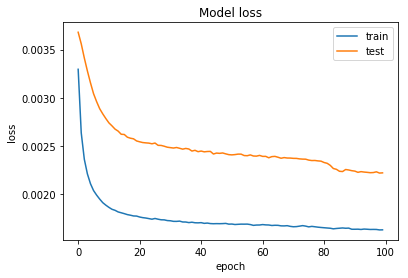

In [30]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [31]:
#Load the model for prediction
autoencoder = load_model('model_news20.h5')
predictions = autoencoder.predict(X_test)
members.append(autoencoder)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

error_df.describe()


,reconstruction_error,true_class
count,7299.000000,7299.000000
mean,0.001918,0.946705
std,0.000136,0.224636
min,0.001214,0.000000
25%,0.001884,1.000000
50%,0.001935,1.000000
75%,0.001980,1.000000
max,0.002478,1.000000


In [32]:
auto_score_pred = []
for scor in predictions.tolist():
    auto_score_pred.append(np.mean(scor))
normalized_auto = [((x-min(auto_score_pred))/(max(auto_score_pred)-min(auto_score_pred))) for x in auto_score_pred]
#print(normalized_auto)

In [33]:
final_train, final_test = data_for_sota()

1    584
Name: new_label, dtype: int64
-1    6910
 1     389
Name: new_label, dtype: int64


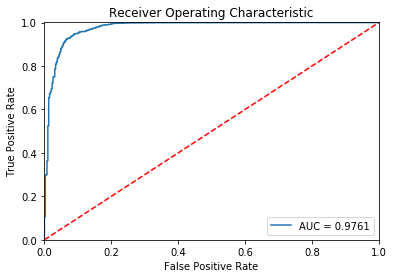

In [35]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [36]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
#plt.plot(recall, precision, 'b', label='Precision-Recall curve')

'''fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
axes[0].plot(recall, precision, 'b', label='Precision-Recall curve')
axes[0].set_title('Recall vs Precision')
axes[1].plot(th, precision[1:], 'b', label='Threshold-Precision curve')
axes[1].set_title('Precision for different threshold values')
axes[2].plot(th, recall[1:], 'b', label='Threshold-Recall curve')
axes[2].set_title('Recall for different threshold values')
fig.tight_layout()'''

"fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))\naxes[0].plot(recall, precision, 'b', label='Precision-Recall curve')\naxes[0].set_title('Recall vs Precision')\naxes[1].plot(th, precision[1:], 'b', label='Threshold-Precision curve')\naxes[1].set_title('Precision for different threshold values')\naxes[2].plot(th, recall[1:], 'b', label='Threshold-Recall curve')\naxes[2].set_title('Recall for different threshold values')\nfig.tight_layout()"

In [37]:
accuracies = []
for threshold in th:
    y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
    accuracies.append(balanced_accuracy_score(error_df.true_class, y_pred))
print("Maximum Test accuracy:", max(accuracies))
#print(accuracies.index(max(accuracies)))
print('Threshold for maximal accuracy: ', th[accuracies.index(max(accuracies))])
threshold = th[accuracies.index(max(accuracies))]
'''fig = plt.figure()
ax = fig.add_subplot(111)
_ = ax.hist(accuracies)'''

Maximum Test accuracy: 0.9292608975479819
Threshold for maximal accuracy:  0.0018184385


'fig = plt.figure()\nax = fig.add_subplot(111)\n_ = ax.hist(accuracies)'

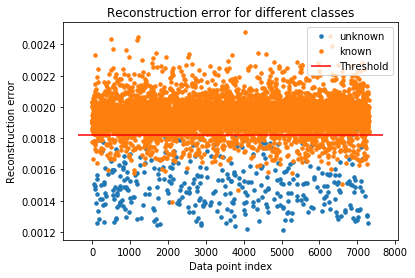

In [38]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "known" if name == 1 else "unknown")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

Test F1 Score:  0.7701674711557395
Test accuracy: 0.9292608975479819


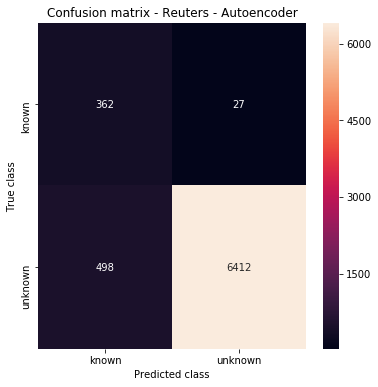

              precision    recall  f1-score   support

           0       0.42      0.93      0.58       389
           1       1.00      0.93      0.96      6910

    accuracy                           0.93      7299
   macro avg       0.71      0.93      0.77      7299
weighted avg       0.97      0.93      0.94      7299



In [39]:
LABELS = ["known", "unknown"]
y_pred_autoencoder = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred_autoencoder,[0,1])
test_f1 = f1_score(error_df.true_class, y_pred_autoencoder, average='macro')  
print('Test F1 Score: ', test_f1)
accuracy = balanced_accuracy_score(error_df.true_class, y_pred_autoencoder)
print("Test accuracy:", accuracy)
results_global_list.append(round(test_f1,2))
results_global_list.append(round(accuracy*100,1))
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix - Reuters - Autoencoder")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
print(classification_report(error_df.true_class, y_pred_autoencoder))

Base individual models end. Ensemble approaches begin from here

In [40]:
for i in range(len(y_pred_autoencoder)):
    if y_pred_autoencoder[i] == 0:
        y_pred_autoencoder[i] = 1
    else:
        y_pred_autoencoder[i] = -1
#print(y_pred_autoencoder)
final_train, final_test = data_for_sota()

1    584
Name: new_label, dtype: int64
-1    6910
 1     389
Name: new_label, dtype: int64


Model:  Ensemble
Test F1 Score:  0.8859110438935573
Test accuracy: 0.9773941635840526


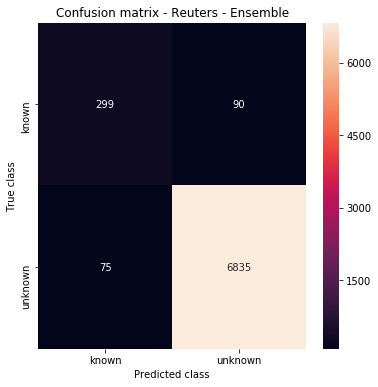

              precision    recall  f1-score   support

          -1       0.99      0.99      0.99      6910
           1       0.80      0.77      0.78       389

    accuracy                           0.98      7299
   macro avg       0.89      0.88      0.89      7299
weighted avg       0.98      0.98      0.98      7299



In [41]:
import math as mt
def mostFrequent(arr): 
    n = len(arr)
    # Insert all elements in Hash. 
    Hash = dict() 
    for i in range(n): 
        if arr[i] in Hash.keys(): 
            Hash[arr[i]] += 1
        else: 
            Hash[arr[i]] = 1
  
    # find the max frequency 
    max_count = 0
    res = -1
    for i in Hash:  
        if (max_count < Hash[i]):  
            res = i 
            max_count = Hash[i] 
          
    return res  

def ensemble_results(model, test_true_labels, test_predicted_labels):
    print('Model: ', model)
    test_f1 = f1_score(test_true_labels, test_predicted_labels, average='macro')  
    print('Test F1 Score: ', test_f1)
    accuracy = accuracy_score(test_true_labels, test_predicted_labels)
    print("Test accuracy:", accuracy)
    results_global_list.append(round(test_f1,2))
    results_global_list.append(round(accuracy*100,1))
    results = confusion_matrix(test_true_labels, test_predicted_labels, [1,-1]) 
    #print('Confusion Matrix :')
    #print(results) 
    #print('Report : ')
    LABELS = ["known", "unknown"]
    plt.figure(figsize=(6, 6))
    sns.heatmap(results, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix - Reuters - " + str(model))
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print(classification_report(test_true_labels, test_predicted_labels))
    
y_pred_test_ensemble = []



for i in range(len(final_test['new_label'].tolist())):
    arr = [ y_pred_test[i], y_pred_iso_test[i], y_pred_autoencoder[i]]
    y_pred_test_ensemble.append(mostFrequent(arr))

ensemble_results('Ensemble', final_test['new_label'].tolist(), y_pred_test_ensemble)

In [42]:
print(results_global_list)

[0.89, 97.8, 0.6, 95.3, 0.77, 92.9, 0.89, 97.7]
